In [ ]:
# Gym
import os
import random
from typing import Any

# helpers
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiBinary, MultiDiscrete, Tuple

# Stable-baseline
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
# from environment import KubernetesEnv

# Custom
from typing import Optional
from database.influxdb import InfluxDB
import logging
from kubernetes import client, config
from utils import setup_logger
from prometheus_api_client import PrometheusConnect
import time
from dotenv import load_dotenv

load_dotenv()

In [ ]:
logger, log_dir = setup_logger(
    "kubernetes_agent", log_level=os.getenv("LOG_LEVEL", "INFO"), log_to_file=True
)

In [ ]:
def wait_for_pods_ready(
    prometheus: PrometheusConnect,
    namespace: str,
    deployment_name: str,
    timeout: int,
    wait_time: int,
    logger: logging.Logger,
):
    start_time = time.time()

    scope_ready = f"""
        (kube_pod_status_ready{{namespace="{namespace}", condition="true"}} == 1)
        and on(pod)
        (
          label_replace(
            kube_pod_owner{{namespace="{namespace}", owner_kind="ReplicaSet"}},
            "replicaset", "$1", "owner_name", "(.*)"
          )
          * on(namespace, replicaset) group_left(owner_name)
            kube_replicaset_owner{{
              namespace="{namespace}", owner_kind="Deployment", owner_name="{deployment_name}"
            }}
        )
    """  # noqa: E501
    q_desired = f"""
    scalar(
      sum(
        kube_deployment_spec_replicas{{namespace="{namespace}",
        deployment="{deployment_name}"}}
      )
    )
    """
    q_ready = f"""
      scalar(sum({scope_ready}))
    """

    while time.time() - start_time < timeout:
        desired_result = prometheus.custom_query(q_desired)
        desired = desired_result[1]
        ready_result = prometheus.custom_query(query=q_ready)
        ready = ready_result[1]
        if ready == desired:
            time.sleep(wait_time)
            return True, desired, ready
        logger.debug(
            f"Waiting for pods to be ready: {ready}/{desired}"
        )
        time.sleep(1)
    time.sleep(wait_time)
    return False, desired, ready

In [ ]:
def _metrics_query(
    namespace: str,
    deployment_name: str,
    interval: int = 15,
    desired_replicas: int | None = None,
    quantile: float = 0.90,
    endpoints_method: list[tuple[str, str]] = (("/", "GET"), ("/docs", "GET")),
) -> tuple[str, str, str, str, str]:
    """
    Build pod-scoped queries and cap to the youngest desired pods.

    We use topk on pod start time to keep only the newest N pods (desired replicas),
    so older pods that are still Ready after a scale-down do not contribute.
    """
    # Default to a reasonable cap if desired_replicas is None
    pod_window = max(1, desired_replicas or 50)

    pod_filter = f"""
        topk({pod_window},
          kube_pod_start_time{{
            namespace="{namespace}",
            pod=~"{deployment_name}-.*"
          }}
          * on(pod) group_left()
            (kube_pod_status_ready{{
                namespace="{namespace}",
                pod=~"{deployment_name}-.*",
                condition="true"
            }} == 1)
        )
    """

    cpu_query = f"""
        sum by (pod) (
            rate(container_cpu_usage_seconds_total{{
                namespace="{namespace}",
                pod=~"{deployment_name}-.*",
                container!="",
                container!="POD"
            }}[{interval}s])
        )
        * on(pod) group_left() {pod_filter}
        """

    memory_query = f"""
        sum by (pod) (
            container_memory_working_set_bytes{{
                namespace="{namespace}",
                pod=~"{deployment_name}-.*",
                container!="",
                container!="POD"
            }}
        )
        * on(pod) group_left() {pod_filter}
        """

    cpu_limits_query = f"""
        sum by (pod) (
            kube_pod_container_resource_limits{{
                namespace="{namespace}",
                pod=~"{deployment_name}-.*",
                resource="cpu",
                unit="core"
            }}
        )
        * on(pod) group_left() {pod_filter}
        """

    # Query for memory limits
    memory_limits_query = f"""
        sum by (pod) (
            kube_pod_container_resource_limits{{
                namespace="{namespace}",
                pod=~"{deployment_name}-.*",
                resource="memory",
                unit="byte"
            }}
        )
        * on(pod) group_left() {pod_filter}
        """

    response_time_query = []
    for endpoint, method in endpoints_method:
        response_time_query.append(f"""
                1000 *
                histogram_quantile(
                {quantile},
                sum by (le) (
                    rate(http_request_duration_seconds_bucket{{
                    namespace="{namespace}",
                    pod=~"{deployment_name}-.*",
                    method="{method}",
                    path="{endpoint}"
                    }}[{interval}s])
                )
                )
            """
        )
    return (
        cpu_query,
        memory_query,
        cpu_limits_query,
        memory_limits_query,
        response_time_query,
    )

In [ ]:
def process_metrics(cpu_usage, memory_usage, cpu_limits, memory_limits, response_times, max_response_time):
    cpu_percentages = []
    memory_percentages = []

    cpu_limits_by_pod = {}
    memory_limits_by_pod = {}
    for item in cpu_limits:
        pod = item["metric"]["pod"]
        limit = float(item["value"][1])
        cpu_limits_by_pod[pod] = limit

    for item in memory_limits:
        pod = item["metric"]["pod"]
        limit = float(item["value"][1])
        memory_limits_by_pod[pod] = limit

    for result in cpu_usage:
        pod_name = result["metric"].get("pod")
        limit = float(cpu_limits_by_pod.get(pod_name))
        rate_cores = float(result["value"][1])
        cpu_percentage = (rate_cores / limit) * 100
        cpu_percentages.append(cpu_percentage)

    for result in memory_usage:
        pod_name = result["metric"].get("pod")
        limit = float(memory_limits_by_pod.get(pod_name))
        usage_bytes = float(result["value"][1])
        memory_percentage = (usage_bytes / limit) * 100
        memory_percentages.append(memory_percentage)

    response_time = np.mean(response_times) if response_times else 0.0
    response_time_percentage = (response_time / max_response_time) * 100.0
    response_time_percentage = min(response_time_percentage, 1000.0)

    return np.mean(cpu_percentages), np.mean(memory_percentages), response_time_percentage

In [ ]:
def get_metrics(
    prometheus: PrometheusConnect,
    namespace: str,
    deployment_name: str,
    interval: int,
    replica: int,
    max_response_time: float,
):
    (
        cpu_query,
        memory_query,
        cpu_limits_query,
        memory_limits_query,
        response_time_query,
    )= _metrics_query(
        namespace,
        deployment_name,
        interval=interval,
        desired_replicas=replica,
    )
    cpu_usage_results = prometheus.custom_query(cpu_query)
    memory_usage_results = prometheus.custom_query(memory_query)
    cpu_limits_results = prometheus.custom_query(cpu_limits_query)
    memory_limits_results = prometheus.custom_query(memory_limits_query)

    response_time_results = []
    for query in response_time_query:
        response = prometheus.custom_query(query)
        if not response:
            response_time_results.append(0.0)
            continue

        response_time_results.append(float(response[0]["value"][1]))

    cpu_percentages, memory_percentages, response_time_percentage = process_metrics(
        cpu_usage_results,
        memory_usage_results,
        cpu_limits_results,
        memory_limits_results,
        response_time_results,
        max_response_time,
    )

    return cpu_percentages, memory_percentages, response_time_percentage

In [ ]:
class KubernetesEnv(Env):
    def __init__(
        self,
        min_replicas: int,
        max_replicas: int,
        iteration: int,
        namespace: str,
        deployment_name: str,
        min_cpu: float,
        min_memory: float,
        max_cpu: float,
        max_memory: float,
        max_response_time: float,
        timeout: int,
        wait_time: int,
        logger: Optional[logging.Logger],
        influxdb: Optional[InfluxDB],
        prometheus_url: str,
        metrics_interval: int,
        metrics_quantile: float,
        max_scaling_retries: int,
        weight_response_time: float,
        weight_cost: float,
        metrics_endpoints_method: list[tuple[str, str]] = (
            ("/cpu", "GET"),
            ("/memory", "GET"),
        ),
    ):
        config.load_kube_config()
        self.api = client.AppsV1Api()
        self.namespace = namespace
        self.deployment_name = deployment_name
        self.prometheus = PrometheusConnect(
            url=prometheus_url,
            disable_ssl=True,
        )
        self.timeout = timeout
        self.wait_time = wait_time
        self.metrics_interval = metrics_interval
        self.metrics_quantile = metrics_quantile
        self.metrics_endpoints_method = metrics_endpoints_method
        self.logger = logger
        self.action_space = Discrete(100)
        self.observation_space = Box(
            low=np.array([0.0, 0.0, 0.0, -2.0, -2.0, 0.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0, 2.0, 2.0, 3.0], dtype=np.float32),
            dtype=np.float32,
        )
        self.iteration = iteration
        self.iteration_init = iteration
        self.min_replicas: int = min_replicas
        self.max_replicas: int = max_replicas
        self.range_replicas: int = max(1, self.max_replicas - self.min_replicas)
        self.max_response_time: float = max_response_time
        self.min_cpu: float = min_cpu
        self.min_memory: float = min_memory
        self.max_cpu: float = max_cpu
        self.max_memory: float = max_memory
        self.influxdb = influxdb
        self.max_scaling_retries = max_scaling_retries

        self.weight_response_time = weight_response_time
        self.weight_cost = weight_cost

        # Calculate max_response_penalty dynamically to ensure reward range [-1, 1]
        # max penalty needed = 2.0 (so 1.0 - 2.0 = -1.0)
        # When RT is bad, cost_weight_multiplier = 0, so only RT penalty applies
        # weight_response_time * max_response_penalty = 2.0
        self.max_response_penalty = 2.0 / self.weight_response_time

        self.observations = np.array(
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            dtype=np.float32,
        )
        self.last_reward = 0.0

    def step(self, action: int):
        self.iteration -= 1
        replica = int(action * self.range_replicas // 100 + self.min_replicas)

        cpu, memory, response_time = self.scale(replica)


        cpu_relative, memory_relative, cpu_distance, memory_distance = self.calculate_distance(cpu, memory)

        reward = self.calculate_reward(action=action, response_time=response_time)
        self.last_reward = reward

        self.observations = self.observation(action=action, response_time=response_time, cpu_relative=cpu_relative, memory_relative=memory_relative, cpu_distance=cpu_distance, memory_distance=memory_distance)


        if self.iteration <= 0:
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False

        info = {
            "cpu": cpu,
            "memory": memory,
            "response_time": response_time,
            "replicas": replica,
            "action": action,
            "cpu_relative": cpu_relative,
            "memory_relative": memory_relative,
            "cpu_distance": cpu_distance,
            "memory_distance": memory_distance,
        }
        if self.influxdb :
            self.influxdb.write_point(
                measurement="autoscaling_metrics",
                tags={
                    "namespace": self.namespace,
                    "deployment": self.deployment_name,
                },
                fields={**info},
            )

        return self.observations, reward, terminated, truncated, info

    def scale(self, replica: int) -> None:
        attempt = 0
        while attempt < self.max_scaling_retries:
            attempt += 1
            delay = min(1 * (2 ** (attempt - 1)), 10)
            try:
                self.api.patch_namespaced_deployment_scale(
                    name=self.deployment_name,
                    namespace=self.namespace,
                    body={"spec": {"replicas": replica}},
                )
                break
            except Exception as e:
                self.logger.error(f"Error scaling deployment: {e}")
                time.sleep(delay)

        _, _, _ = wait_for_pods_ready(
            prometheus=self.prometheus,
            deployment_name=self.deployment_name,
            namespace=self.namespace,
            timeout=self.timeout,
            wait_time=self.wait_time,
            logger=self.logger,
        )
        cpu, memory, response_time = get_metrics(
            prometheus=self.prometheus,
            namespace=self.namespace,
            deployment_name=self.deployment_name,
            interval=self.metrics_interval,
            replica=replica,
            max_response_time=self.max_response_time,
        )
        return cpu, memory, response_time

    def calculate_reward(self, action: int, response_time: float) -> float:
        RESPONSE_TIME_HIGH_THRESHOLD = 80.0
        RESPONSE_TIME_VIOLATION_THRESHOLD = 100.0

        if response_time <= RESPONSE_TIME_HIGH_THRESHOLD:
            response_time_penalty = 0.0
        elif response_time <= RESPONSE_TIME_VIOLATION_THRESHOLD:
            response_time_penalty = (response_time - RESPONSE_TIME_HIGH_THRESHOLD) / (
                RESPONSE_TIME_VIOLATION_THRESHOLD - RESPONSE_TIME_HIGH_THRESHOLD
            )
        else:
            over = (
                response_time - RESPONSE_TIME_VIOLATION_THRESHOLD
            ) / RESPONSE_TIME_VIOLATION_THRESHOLD
            response_time_penalty = 1.0 + over

        response_time_penalty = max(0.0, min(response_time_penalty, self.max_response_penalty))

        cost_penalty_raw = action / 99.0

        if response_time <= RESPONSE_TIME_HIGH_THRESHOLD:
            cost_weight_multiplier = 1.0
        elif response_time <= RESPONSE_TIME_VIOLATION_THRESHOLD:
            cost_weight_multiplier = 1.0 - (response_time_penalty / self.max_response_penalty)
        else:
            cost_weight_multiplier = 0.0

        effective_cost_penalty = cost_penalty_raw * cost_weight_multiplier

        total_penalty = (
            self.weight_response_time * response_time_penalty
            + self.weight_cost * effective_cost_penalty
        )
        return 1.0 - total_penalty

    def calculate_distance(self,cpu: float, memory: float) -> tuple[float, float]:
        cpu_distance = (
            (self.min_cpu - cpu) if cpu < self.min_cpu else (cpu - self.max_cpu)
        )
        cpu_bandwidth = self.max_cpu - self.min_cpu
        cpu_normalized = cpu_distance / cpu_bandwidth
        cpu_distance = cpu_normalized
        cpu_relative = (cpu - self.min_cpu) / cpu_bandwidth


        memory_distance = (
            (self.min_memory - memory)
            if memory < self.min_memory
            else (memory - self.max_memory)
        )
        memory_bandwidth = self.max_memory - self.min_memory
        memory_normalized = memory_distance / memory_bandwidth
        memory_distance = memory_normalized
        memory_relative = (memory - self.min_memory) / memory_bandwidth

        return cpu_relative, memory_relative, cpu_distance, memory_distance

    def observation(self, action: int, response_time: float, cpu_relative: float, memory_relative: float, cpu_distance: float, memory_distance: float):
        action = action / 99.0

        cpu_relative = float(np.clip(cpu_relative, 0.0, 1.0))
        memory_relative = float(np.clip(memory_relative, 0.0, 1.0))
        cpu_distance = float(np.clip(cpu_distance, -2.0, 2.0))
        memory_distance = float(np.clip(memory_distance, -2.0, 2.0))
        response_time = float(np.clip(response_time / 100.0, 0.0, 3.0))


        return np.array(
            [
                action,
                cpu_relative,
                memory_relative,
                cpu_distance,
                memory_distance,
                response_time,
            ],
            dtype=np.float32,
        )

    def render(self) -> None:
        def _color(v: float, warn: float, crit: float, reverse: bool = False) -> str:
            GREEN, YELLOW, RED = "\033[32m", "\033[33m", "\033[31m"

            if reverse:
                ok = v <= warn
                mid = warn < v <= crit
            else:
                ok = v < warn
                mid = warn <= v < crit
                if v >= crit:
                    return RED

            return GREEN if ok else (YELLOW if mid else RED)

        def _clamp(v: float, lo: float = 0.0, hi: float = 100.0) -> float:
            return max(lo, min(hi, v))

        def _bar(pct: float, width: int = 12) -> str:
            pct = _clamp(pct)
            filled = round(pct / 100 * width)
            return "█" * filled + "░" * (width - filled)

        def _fmt_pct(v: float) -> str:
            try:
                return f"{float(v):6.2f}%"
            except Exception:
                return f"{v}"

        action = int(self.observations[0] * 99)
        cpu = self.observations[1] * 100.0
        mem = self.observations[2] * 100.0
        cpu_distance = self.observations[3]
        mem_distance = self.observations[4]
        rt = self.observations[5] * 100.0

        def _dist_color(dist: float) -> str:
            GREEN, YELLOW, RED = "\033[32m", "\033[33m", "\033[31m"
            if -0.1 <= dist <= 0.1:
                return GREEN
            elif dist < -0.3 or dist > 0.5:
                return RED
            return YELLOW

        cpu_col = _dist_color(cpu_distance)
        mem_col = _dist_color(mem_distance)
        rt_col = _color(rt, warn=80, crit=100)

        cpu_bar = _bar(cpu)
        mem_bar = _bar(mem)
        rt_bar = _bar(min(rt, 200.0), width=12)

        RESET = "\033[0m"

        # line 1
        hdr = "▶ "
        cpu_str = f"{cpu_col}CPU {_fmt_pct(cpu)} {cpu_bar}{RESET}"
        mem_str = f"{mem_col}MEM {_fmt_pct(mem)} {mem_bar}{RESET}"
        rt_str = f"{rt_col}RT {rt:6.1f}% {rt_bar}{RESET}"
        act_str = f"ACT {action:3d}"
        cpu_dist_str = f"CPU_D {cpu_distance:+7.3f}"
        mem_dist_str = f"MEM_D {mem_distance:+7.3f}"
        reward_str = f"RWD {self.last_reward:+6.3f}"
        self.logger.info(
            f"{' ' * len(hdr)}| {cpu_str} | {mem_str} | {rt_str} | "
            f"{cpu_dist_str} | {mem_dist_str} | {act_str} | {reward_str} |"
        )

    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict[str, Any] | None = None,
    ):
        self.iteration = self.iteration_init
        action = random.randint(0, 99)
        replica = int(action * self.range_replicas // 100 + self.min_replicas)

        cpu, memory, response_time = self.scale(replica)

        cpu_relative, memory_relative, cpu_distance, memory_distance = self.calculate_distance(cpu, memory)

        self.observations = self.observation(action=action, response_time=response_time, cpu_relative=cpu_relative, memory_relative=memory_relative, cpu_distance=cpu_distance, memory_distance=memory_distance)

        info = {
            "cpu": cpu,
            "memory": memory,
            "response_time": response_time,
            "replicas": replica,
            "action": action,
            "cpu_relative": cpu_relative,
            "memory_relative": memory_relative,
            "cpu_distance": cpu_distance,
            "memory_distance": memory_distance,
        }

        return self.observations, info

In [ ]:
influxdb = InfluxDB(
    logger=logger,
    url=os.getenv("INFLUXDB_URL", "http://localhost:8086"),
    token=os.getenv("INFLUXDB_TOKEN", "my-token"),
    org=os.getenv("INFLUXDB_ORG", "my-org"),
    bucket=os.getenv("INFLUXDB_BUCKET", "my-bucket"),
)

env = KubernetesEnv(
    min_replicas=int(os.getenv("MIN_REPLICAS")),
    max_replicas=int(os.getenv("MAX_REPLICAS")),
    iteration=int(os.getenv("ITERATION")),
    namespace=os.getenv("NAMESPACE"),
    deployment_name=os.getenv("DEPLOYMENT_NAME"),
    min_cpu=float(os.getenv("MIN_CPU")),
    min_memory=float(os.getenv("MIN_MEMORY")),
    max_cpu=float(os.getenv("MAX_CPU")),
    max_memory=float(os.getenv("MAX_MEMORY")),
    max_response_time=float(os.getenv("MAX_RESPONSE_TIME")),
    timeout=int(os.getenv("TIMEOUT")),
    wait_time=int(os.getenv("WAIT_TIME")),
    logger=logger,
    influxdb=influxdb,
    prometheus_url=os.getenv("PROMETHEUS_URL"),
    metrics_endpoints_method=[("/", "GET"), ("/docs", "GET")],
    metrics_interval=int(os.getenv("METRICS_INTERVAL")),
    metrics_quantile=float(os.getenv("METRICS_QUANTILE")),
    max_scaling_retries=int(os.getenv("MAX_SCALING_RETRIES")),
    weight_response_time=float(os.getenv("WEIGHT_RESPONSE_TIME")),
    weight_cost=float(os.getenv("WEIGHT_COST")),
)

In [ ]:
env.observation_space.sample()

In [ ]:
env.action_space.sample()

In [ ]:
# episodes = 10
# for episode in range(1, episodes+1):
#     env.reset()
#     terminated = False
#     truncated = False
#     score = 0

#     while not terminated and not truncated:
#         action = env.action_space.sample()
#         obs, reward, terminated, truncated , info = env.step(action)
#         env.render()
#         score += reward
#     print(f"Episode: {episode}  Score {score}")
# env.close()

In [ ]:
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)

In [ ]:
model.learn(20000, reset_num_timesteps=False, progress_bar=True)
model.save()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

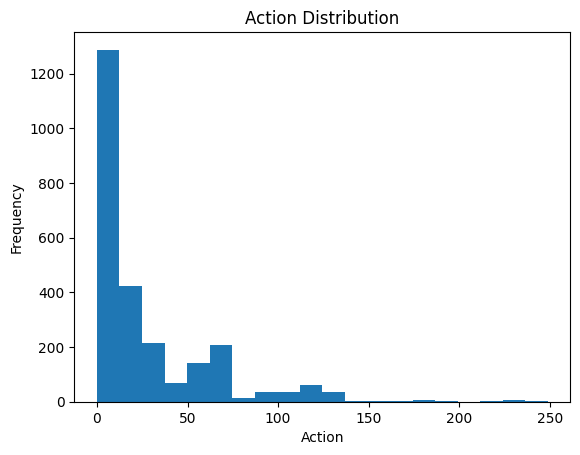

In [12]:
df = pd.read_csv("data/2025-12-19-21-15_offline_add_estimation.csv")


plt.figure()
plt.hist(df["response_time"], bins=20)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution")
plt.show()


In [14]:

from offline_train import OfflineEnv
test_env = OfflineEnv()
test_env.data = df.reset_index(drop=True)
obs, _ = test_env.reset()

print(f"Initial obs: {obs}")
assert 0 <= obs[1] <= 1, f"CPU not normalized: {obs[1]}"
assert 0 <= obs[2] <= 1, f"Memory not normalized: {obs[2]}"
print("✓ Normalization test passed")

Initial obs: [0.75757575 0.01387174 0.19210358 0.        ]
✓ Normalization test passed
